<CENTER>
</br>
<p><font size="5">  M2MO & EY - Internship </font></p>
<p><font size="5">  Modelling Initial Margin and Counterparty Risk in Uncleared Derivatives </font></p>
<p><font size="4">  SANGLIER Nathan </font></p>
<p><font size="3"></br>May 2025</font></br></div>
<p><span style="color:blue">nathan.sanglier@etu.u-paris.fr</span>
</p>
</CENTER>

In [13]:
import  utils
import  numpy               as      np
import  matplotlib.pyplot   as      plt

np.random.seed(0)
plt.style.use('ggplot')

In [14]:
color_jlsmc     = 'blue'
color_invalid   = 'purple'

In [ ]:
# 1/24 = 1 week. 1Y = 6M | 1M = 4W --> 1Y = 24W
# 1/240 = 1/2 bday. 1W = 5 bdays
r, S0, sigma, T, delta, dt = 0.05, 100, 0.3, 1, 1/24, 1/240

time_grid   = np.arange(0, T, dt)
N           = len(time_grid)-1
M           = 200000
tref        = 1/12 # 1/12 : 1 month
ind_tref, ind_delta, ind_tdelta = int(tref/dt), int(delta/dt), int((tref+delta)/dt)
Sref        = 100 # 100
alpha       = 0.99
K           = 95

In [16]:
gen_riskfactors = lambda S0, M, N: utils.gen_riskfactors(S0, r, sigma, dt, M, N)
gen_mtm         = lambda S_paths, time_grid: utils.gen_mtm(S_paths, r, sigma, K, T, time_grid)
get_mtmdiff_nmc = lambda M_in, S, mtm, ind_tref: utils.get_mtmdiff_nmc(M_in, S, mtm, r, sigma, dt, K, T, ind_tref, ind_delta, time_grid)

In [17]:
S_paths         = gen_riskfactors(S0, M, N)
mtm_paths       = gen_mtm(S_paths, time_grid)
mtmdiff_paths   = mtm_paths[:, ind_delta:] - mtm_paths[:, :-ind_delta]
S_train         = S_paths[:, ind_tref]
mtm_train       = mtm_paths[:, ind_tref]
mtm_func        = np.linspace(np.min(mtm_train), np.max(mtm_train), 1000)

Nq          = 100
Nqtail      = int(0.1*Nq)//2
q_main      = np.arange(1, Nq) / Nq
q_ltail     = np.linspace(0, 0.01, Nqtail+2)[1:-1]
q_utail     = np.linspace(0.99, 1, Nqtail+2)[1:-1]
q_all       = np.sort(np.unique(np.concatenate([q_ltail, q_main, q_utail])))
mtm_supp    = np.quantile(mtm_train, q_all, method='inverted_cdf')

Mtest                           = 100
Mtest_in                        = 100000
S_test                          = np.linspace(np.min(S_train), np.max(S_train), Mtest)
mtm_test                        = gen_mtm(S_test.reshape(-1, 1), time_grid[ind_tref:ind_tref+1])
mtmdiff_nmc_test                = get_mtmdiff_nmc(Mtest_in, S_test, mtm_test, ind_tref)
muraw_test                      = np.column_stack([np.mean(mtmdiff_nmc_test**i, axis=1) for i in range(1, 5)])
mu_test                         = utils.get_centred_moms(muraw_test)[0]
skew_test, kurt_test, _, _, _   = utils.get_skewkurt(mu_test)

In [18]:
settings_list = [
    {'id': 0, 'method': 'LR', 'ridge': 0, 'basis_type': 'laguerre', 'order': 2, 'regress_mean': True},
    {'id': 1, 'method': 'LR', 'ridge': 0, 'basis_type': 'laguerre', 'order': 4, 'regress_mean': True},
    {'id': 2, 'method': 'HR', 'ridge': 0, 'epsilon': 100, 'basis_type': 'laguerre', 'order': 7, 'regress_mean': True},
    {'id': 3, 'method': 'GLM', 'ridge': 0, 'basis_type': 'laguerre', 'order': 2, 'regress_mean': True},
    {'id': 4, 'method': 'GLM', 'ridge': 0, 'basis_type': 'laguerre', 'order': 4, 'regress_mean': True},
    {'id': 5, 'method': 'KR', 'bandwidth': 'silverman', 'regress_mean': True},
    {'id': 6, 'method': 'LR', 'ridge': 0, 'basis_type': 'laguerre', 'order': 2, 'regress_mean': False},
    {'id': 7, 'method': 'LR', 'ridge': 0, 'basis_type': 'laguerre', 'order': 4, 'regress_mean': False},
    {'id': 8, 'method': 'HR', 'ridge': 0, 'epsilon': 100, 'basis_type': 'laguerre', 'order': 7, 'regress_mean': False},
    {'id': 9, 'method': 'GLM', 'ridge': 0, 'basis_type': 'laguerre', 'order': 2, 'regress_mean': False},
    {'id': 10, 'method': 'GLM', 'ridge': 0, 'basis_type': 'laguerre', 'order': 4, 'regress_mean': False},
    {'id': 11, 'method': 'KR', 'bandwidth': 'silverman', 'regress_mean': False},
]
order_moms = 4

setting = settings_list[0]

In [19]:
mtmpred_list            = [mtm_test, mtm_func, mtm_supp]
ytrain                  = mtmdiff_paths[:, ind_tref:ind_tref+1]**np.arange(1, order_moms+1)
yhat_pred_list, runtime = utils.regress_moms(mtm_train, ytrain, mtmpred_list, setting, order_moms)
print(f"Time taken for moments regression: {runtime:.2f} seconds")

murawhat_test, murawhat_func, murawhat_supp = yhat_pred_list[0], yhat_pred_list[1], yhat_pred_list[2]
muhat_test, maskhat_test = utils.get_centred_moms(murawhat_test)
muhat_func, maskhat_func = utils.get_centred_moms(murawhat_func)
muhat_supp, maskhat_supp = utils.get_centred_moms(murawhat_supp)
skewhat_test, kurthat_test, mask_skewhat_test, mask_kurthat_test, mask_tothat_test = utils.get_skewkurt(muhat_test, maskhat_test)
skewhat_func, kurthat_func, mask_skewhat_func, mask_kurthat_func, mask_tothat_func = utils.get_skewkurt(muhat_func, maskhat_func)
skewhat_supp, kurthat_supp, mask_skewhat_supp, mask_kurthat_supp, mask_tothat_supp = utils.get_skewkurt(muhat_supp, maskhat_supp)

Time taken for moments regression: 0.07 seconds


c:\Users\CF518AW\OneDrive - EY\Documents\STAGE\EY-Initial-Margin\least_squares_mc\utils.py:141: RuntimeWarning: invalid value encountered in power
  get_skew = lambda mu2, mu3: mu3 / mu2**(3/2)


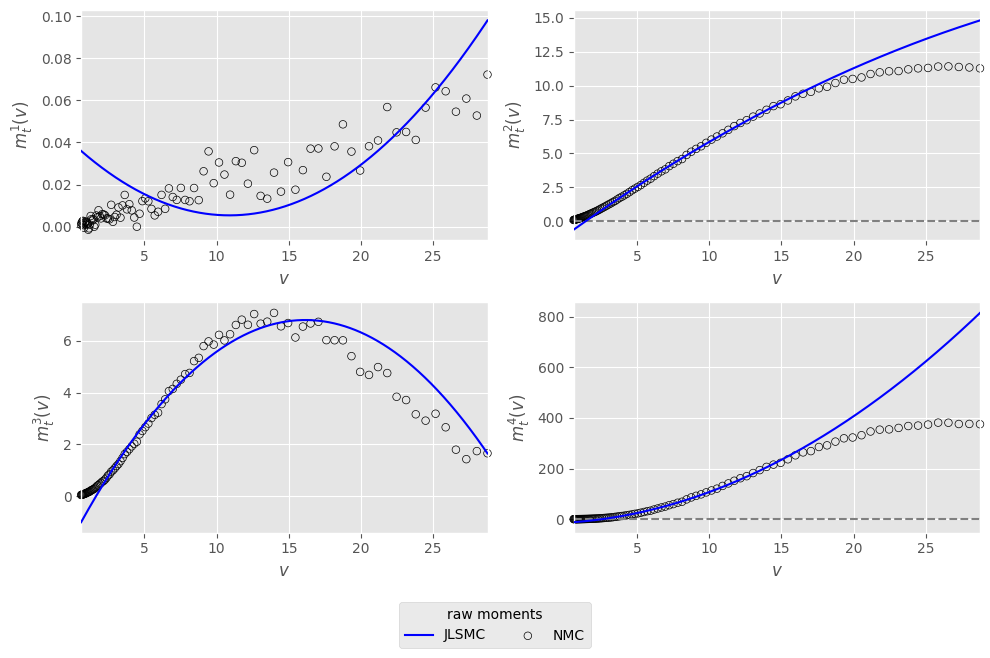

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0, 0].plot(mtm_func, murawhat_func[:, 0], color=color_jlsmc, label='JLSMC', zorder=3)
axs[0, 0].scatter(mtm_test, muraw_test[:, 0], color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0, 0].set_xlabel('$v$')
axs[0, 0].set_ylabel('$m_t^1(v)$')
axs[0, 0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[0, 1].plot(mtm_func, murawhat_func[:, 1], color=color_jlsmc, zorder=3)
axs[0, 1].scatter(mtm_test, muraw_test[:, 1], color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[0, 1].axhline(0, color='grey', linestyle='--')
axs[0, 1].set_xlabel('$v$')
axs[0, 1].set_ylabel('$m_t^2(v)$')
axs[0, 1].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1, 0].plot(mtm_func, murawhat_func[:, 2], color=color_jlsmc, zorder=3)
axs[1, 0].scatter(mtm_test, muraw_test[:, 2], color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1, 0].set_xlabel('$v$')
axs[1, 0].set_ylabel('$m_t^3(v)$')
axs[1, 0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1, 1].plot(mtm_func, murawhat_func[:, 3], color=color_jlsmc, zorder=3)
axs[1, 1].scatter(mtm_test, muraw_test[:, 3], color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1, 1].axhline(0, color='grey', linestyle='--')
axs[1, 1].set_xlabel('$v$')
axs[1, 1].set_ylabel('$m_t^4(v)$')
axs[1, 1].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1), title='raw moments')

plt.tight_layout()
# plt.savefig(f'figures/moments_regression/time_{tref:.2f}_set{setting['id']}_rawmoms.png', dpi=300, bbox_inches='tight')
plt.show()

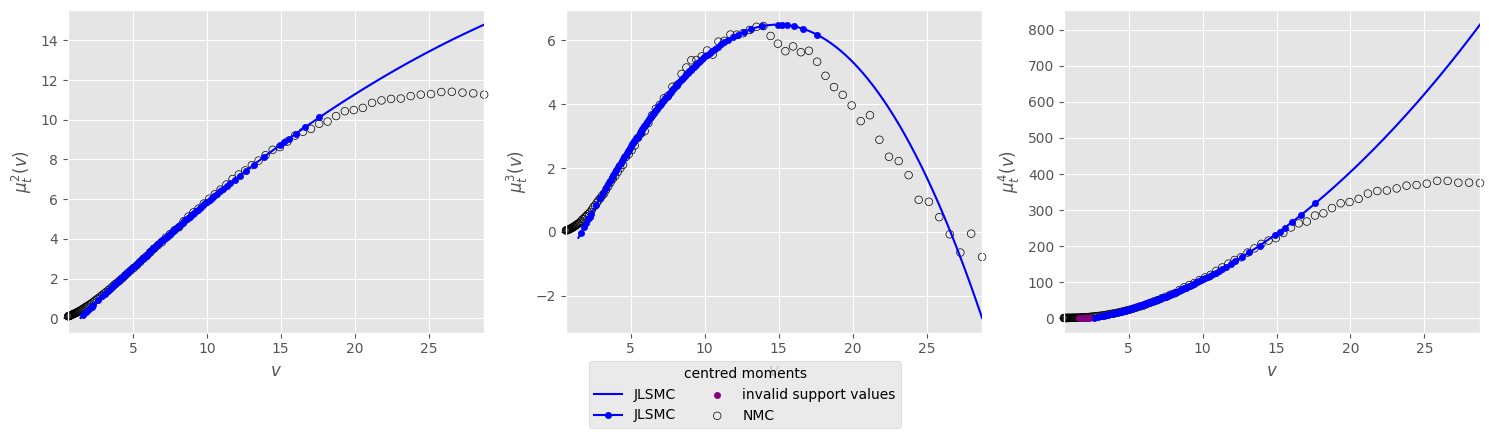

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(mtm_func[maskhat_func[:, 0]], muhat_func[maskhat_func[:, 0], 0], color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].plot([None], [None], marker='o', markersize=4, color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].scatter(mtm_supp[maskhat_supp[:, 0]], muhat_supp[maskhat_supp[:, 0], 0], color=color_jlsmc, s=20, zorder=3)
axs[0].scatter(mtm_supp[~maskhat_supp[:, 0]], np.zeros_like(mtm_supp[~maskhat_supp[:, 0]]), color=color_invalid, s=20, label='invalid support values', zorder=3)
axs[0].scatter(mtm_test, mu_test[:, 0], color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$\\mu_t^2(v)$')
axs[0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1].plot(mtm_func[maskhat_func[:, 1]], muhat_func[maskhat_func[:, 1], 1], color=color_jlsmc, zorder=3)
axs[1].scatter(mtm_supp[maskhat_supp[:, 1]], muhat_supp[maskhat_supp[:, 1], 1], color=color_jlsmc, s=20, zorder=3)
axs[1].scatter(mtm_supp[~maskhat_supp[:, 1]], np.zeros_like(mtm_supp[~maskhat_supp[:, 1]]), color=color_invalid, s=20, zorder=3)
axs[1].scatter(mtm_test, mu_test[:, 1], color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\mu_t^3(v)$')
axs[1].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[2].plot(mtm_func[maskhat_func[:, 2]], muhat_func[maskhat_func[:, 2], 2], color=color_jlsmc, zorder=3)
axs[2].scatter(mtm_supp[maskhat_supp[:, 2]], muhat_supp[maskhat_supp[:, 2], 2], color=color_jlsmc, s=20, zorder=3)
axs[2].scatter(mtm_supp[~maskhat_supp[:, 2]], np.zeros_like(mtm_supp[~maskhat_supp[:, 2]]), color=color_invalid, s=20, zorder=3)
axs[2].scatter(mtm_test, mu_test[:, 2], color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[2].set_xlabel('$v$')
axs[2].set_ylabel('$\\mu_t^4(v)$')
axs[2].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1), title='centred moments')

plt.tight_layout()
plt.show()

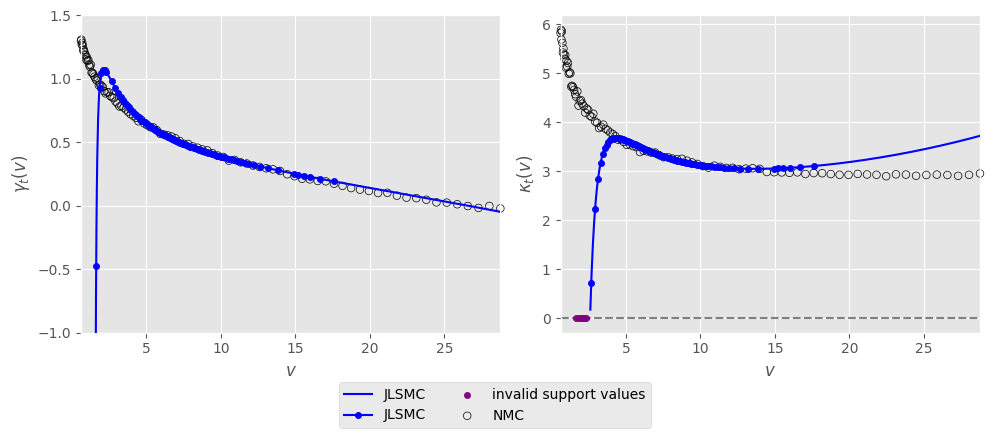

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(mtm_func[mask_skewhat_func], skewhat_func[mask_skewhat_func], color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].plot([None], [None], marker='o', markersize=4, color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].scatter(mtm_supp[mask_skewhat_supp], skewhat_supp[mask_skewhat_supp], color=color_jlsmc, s=20, zorder=3)
axs[0].scatter(mtm_supp[~mask_skewhat_supp], np.zeros_like(mtm_supp[~mask_skewhat_supp]), color=color_invalid, s=20, label='invalid support values', zorder=3)
axs[0].scatter(mtm_test, skew_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$\\gamma_t(v)$')
axs[0].set_xlim(np.min(mtm_func), np.max(mtm_func))
axs[0].set_ylim(bottom=-1, top=1.5)

axs[1].plot(mtm_func[mask_kurthat_func], kurthat_func[mask_kurthat_func], color=color_jlsmc, zorder=3)
axs[1].scatter(mtm_supp[mask_kurthat_supp], kurthat_supp[mask_kurthat_supp], color=color_jlsmc, s=20, zorder=3)
axs[1].scatter(mtm_supp[~mask_kurthat_supp], np.zeros_like(mtm_supp[~mask_kurthat_supp]), color=color_invalid, s=20, zorder=3)
axs[1].scatter(mtm_test, kurt_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1].axhline(0, color='grey', linestyle='--')
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\kappa_t(v)$')
axs[1].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.show()

Total nummber of invalid support points: 6


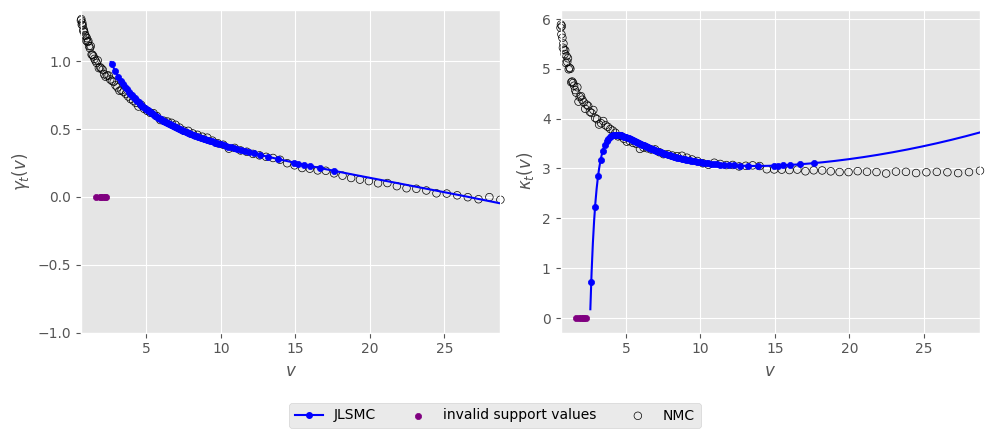

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(mtm_func[mask_tothat_func], skewhat_func[mask_tothat_func], color=color_jlsmc, zorder=3)
axs[0].plot([None], [None], marker='o', markersize=4, color=color_jlsmc, label='JLSMC', zorder=3)
axs[0].scatter(mtm_supp[mask_tothat_supp], skewhat_supp[mask_tothat_supp], color=color_jlsmc, s=20, zorder=3)
axs[0].scatter(mtm_supp[~mask_tothat_supp], np.zeros_like(mtm_supp[~mask_tothat_supp]), color=color_invalid, s=20, label='invalid support values', zorder=3)
axs[0].scatter(mtm_test, skew_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$\\gamma_t(v)$')
axs[0].set_xlim(np.min(mtm_func), np.max(mtm_func))
axs[0].set_ylim(bottom=-1)

axs[1].plot(mtm_func[mask_tothat_func], kurthat_func[mask_tothat_func], color=color_jlsmc, zorder=3)
axs[1].scatter(mtm_supp[mask_tothat_supp], kurthat_supp[mask_tothat_supp], color=color_jlsmc, s=20, zorder=3)
axs[1].scatter(mtm_supp[~mask_tothat_supp], np.zeros_like(mtm_supp[~mask_tothat_supp]), color=color_invalid, s=20, zorder=3)
axs[1].scatter(mtm_test, kurt_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\kappa_t(v)$')
axs[1].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1))

print(f"Total nummber of invalid support points: {np.sum(~mask_tothat_supp)}")

plt.tight_layout()
plt.show()

Total nummber of invalid support points: 6


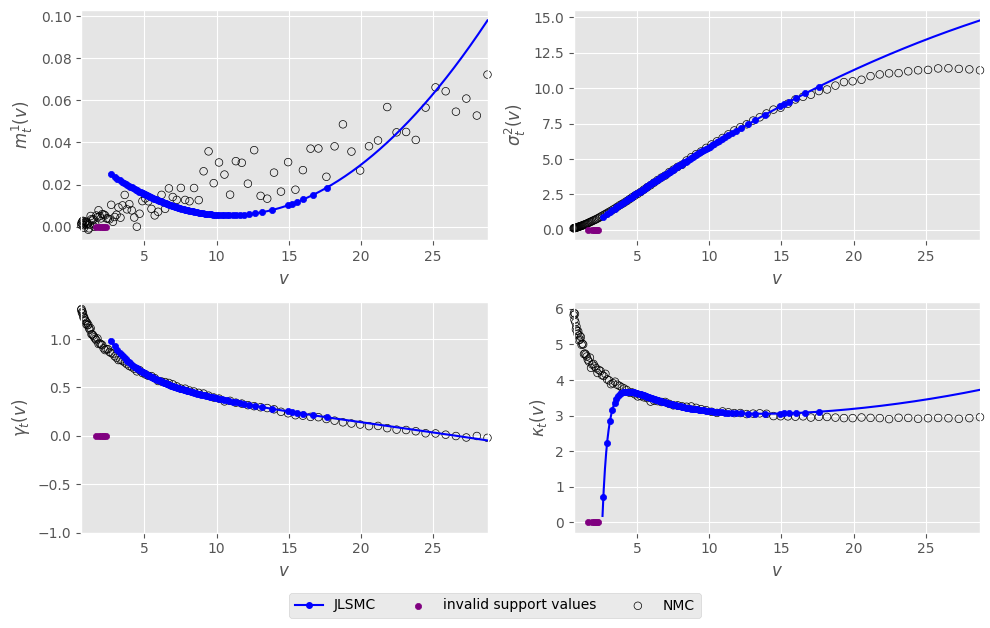

In [24]:
fig, axs    = plt.subplots(2, 2, figsize=(10, 6))
axs         = axs.flatten()

axs[0].plot(mtm_func[mask_tothat_func], murawhat_func[mask_tothat_func, 0], color=color_jlsmc, zorder=3)
axs[0].scatter(mtm_supp[mask_tothat_supp], murawhat_supp[mask_tothat_supp, 0], color=color_jlsmc, s=20, zorder=3)
axs[0].scatter(mtm_supp[~mask_tothat_supp], np.zeros_like(mtm_supp[~mask_tothat_supp]), color=color_invalid, s=20, zorder=3)
axs[0].scatter(mtm_test, muraw_test[:, 0], color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[0].set_xlabel('$v$')
axs[0].set_ylabel('$m^1_t(v)$')
axs[0].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[1].plot(mtm_func[mask_tothat_func], muhat_func[mask_tothat_func, 0], color=color_jlsmc, zorder=3)
axs[1].scatter(mtm_supp[mask_tothat_supp], muhat_supp[mask_tothat_supp, 0], color=color_jlsmc, s=20, zorder=3)
axs[1].scatter(mtm_supp[~mask_tothat_supp], np.zeros_like(mtm_supp[~mask_tothat_supp]), color=color_invalid, s=20, zorder=3)
axs[1].scatter(mtm_test, mu_test[:, 0], color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[1].set_xlabel('$v$')
axs[1].set_ylabel('$\\sigma^2_t(v)$')
axs[1].set_xlim(np.min(mtm_func), np.max(mtm_func))

axs[2].plot(mtm_func[mask_tothat_func], skewhat_func[mask_tothat_func], color=color_jlsmc, zorder=3)
axs[2].plot([None], [None], marker='o', markersize=4, color=color_jlsmc, label='JLSMC', zorder=3)
axs[2].scatter(mtm_supp[mask_tothat_supp], skewhat_supp[mask_tothat_supp], color=color_jlsmc, s=20, zorder=3)
axs[2].scatter(mtm_supp[~mask_tothat_supp], np.zeros_like(mtm_supp[~mask_tothat_supp]), color=color_invalid, s=20, label='invalid support values', zorder=3)
axs[2].scatter(mtm_test, skew_test, color='black', s=30, facecolors='none', label='NMC', clip_on=False, zorder=2)
axs[2].set_xlabel('$v$')
axs[2].set_ylabel('$\\gamma_t(v)$')
axs[2].set_xlim(np.min(mtm_func), np.max(mtm_func))
axs[2].set_ylim(bottom=-1)

axs[3].plot(mtm_func[mask_tothat_func], kurthat_func[mask_tothat_func], color=color_jlsmc, zorder=3)
axs[3].scatter(mtm_supp[mask_tothat_supp], kurthat_supp[mask_tothat_supp], color=color_jlsmc, s=20, zorder=3)
axs[3].scatter(mtm_supp[~mask_tothat_supp], np.zeros_like(mtm_supp[~mask_tothat_supp]), color=color_invalid, s=20, zorder=3)
axs[3].scatter(mtm_test, kurt_test, color='black', s=30, facecolors='none', clip_on=False, zorder=2)
axs[3].set_xlabel('$v$')
axs[3].set_ylabel('$\\kappa_t(v)$')
axs[3].set_xlim(np.min(mtm_func), np.max(mtm_func))

handles, labels = axs[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))

print(f"Total nummber of invalid support points: {np.sum(~mask_tothat_supp)}")

plt.tight_layout()
# plt.savefig(f'figures/moments_regression/time_{tref:.2f}_set{setting['id']}_allmetrics.png', dpi=300, bbox_inches='tight')
plt.show()